# <font color='#1a5276'> <b> <center> Classification </center> </b> </font>

## <font color='blue'>  Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)
3. [Binary Classification](#3) <br>
    3.1. [Helper Functions](#3.1) <br>
    3.2. [Data](#3.2) <br>
    3.3. [Model](#3.3) <br>
    3.4. [Training and evaluation](#3.4) <br>
4. [Multiclass Classification](#4) <br>
    4.1. [Helper Functions](#4.1) <br>
    4.2. [Data](#4.2) <br>
    4.3. [Model](#4.3) <br>
    4.4. [Training and evaluation](#4.4) <br>
5. [References](#references)

<a name="1"></a>
## <font color='blue'> <b> 1. Introduction </b> </font>

This notebook explores the implementation of two classification problems using PyTorch:

- Binary Classification: We'll tackle a binary classification task where the goal is to predict between two distinct classes (e.g., spam/not spam, fraud/not fraud).


- Multiclass Classification: We'll then delve into a multiclass classification problem, where the objective is to predict among multiple classes (e.g., image classification of different animals, sentiment analysis with multiple sentiment levels).


<a name="2"></a>
## <font color='blue'> <b> 2. Setup </b> </font>

In [109]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [110]:
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

In [111]:
# Set random seed
torch.manual_seed(0)

<a name="3"></a>
## <font color='blue'> <b> 3. Binary classification </b> </font>

A binary classification problem is a type of machine learning task where the goal is to classify data into one of two distinct categories or classes. In this type of problem, the model learns to predict a label based on input features, where the output is typically a binary outcome, such as 0 or 1, true or false, or positive or negative.

For example, in a spam email classification problem, the task is to classify emails as either "spam" or "not spam." Similarly, in medical diagnostics, a model might classify whether a patient has a certain disease or not, based on their medical data.

In this project, we will solve the binary classification problem using logistic regression.

<a name="3.1"></a>
### <font color='#1f618d'> <b> 3.1. Helper Functions </b> </font>

In [5]:
# Create class for plotting and the function for plotting

class PlotErrorSurfaces(object):
    
    # Constructor to initialize parameters and compute the error surface
    def __init__(self, w_range, b_range, X, Y, n_samples = 30, go = True):
        # Generate linearly spaced values for weights (w) and biases (b)
        W = np.linspace(-w_range, w_range, n_samples)
        B = np.linspace(-b_range, b_range, n_samples)
        
        # Create a meshgrid for w and b
        w, b = np.meshgrid(W, B)    
        
        # Initialize a zero matrix for storing the error values (Z)
        Z = np.zeros((30, 30))
        count1 = 0
        
        # Convert X and Y to numpy arrays
        self.y = Y.numpy()
        self.x = X.numpy()
        
        # Loop through all combinations of weights (w2) and biases (b2)
        for w1, b1 in zip(w, b):
            count2 = 0
            for w2, b2 in zip(w1, b1):
                # Compute the predicted values using the sigmoid function
                yhat = 1 / (1 + np.exp(-1 * (w2 * self.x + b2)))
                
                # Compute the loss (binary cross-entropy) and store it in Z
                Z[count1, count2] = -1 * np.mean(self.y * np.log(yhat + 1e-16) + (1 - self.y) * np.log(1 - yhat + 1e-16))
                count2 += 1   
            count1 += 1
        
        # Store the computed error surface (Z) and parameters (w, b)
        self.Z = Z
        self.w = w
        self.b = b
        
        # Initialize empty lists for storing the weight, bias, and loss values
        self.W = []
        self.B = []
        self.LOSS = []
        self.n = 0
        
        # If 'go' is True, plot the 3D surface and contour of the loss surface
        if go == True:
            plt.figure()
            plt.figure(figsize=(7.5, 5))
            plt.axes(projection='3d').plot_surface(self.w, self.b, self.Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
            plt.title('Loss Surface')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.show()
            plt.figure()
            plt.title('Loss Surface Contour')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.contour(self.w, self.b, self.Z)
            plt.show()
            
    # Method to set the model's parameters and record the loss
    def set_para_loss(self, model, loss):
        self.n = self.n + 1
        self.W.append(list(model.parameters())[0].item())  # Store weight
        self.B.append(list(model.parameters())[1].item())  # Store bias
        self.LOSS.append(loss)  # Store loss
    
    # Plot final error surface and contour with model parameters
    def final_plot(self): 
        ax = plt.axes(projection='3d')
        ax.plot_wireframe(self.w, self.b, self.Z)  # Plot the 3D wireframe
        ax.scatter(self.W, self.B, self.LOSS, c='r', marker='x', s=200, alpha=1)  # Plot the parameter values with loss
        plt.figure()
        plt.contour(self.w, self.b, self.Z)  # Plot the 2D contour
        plt.scatter(self.W, self.B, c='r', marker='x')  # Plot the parameter values on the contour
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()
        
    # Plot the data space and loss surface contour for each iteration
    def plot_ps(self):
        plt.subplot(121)
        plt.ylim  # Set the y-axis limits
        plt.plot(self.x, self.y, 'ro', label="training points")  # Plot training data
        plt.plot(self.x, self.W[-1] * self.x + self.B[-1], label="estimated line")  # Plot the estimated line
        plt.plot(self.x, 1 / (1 + np.exp(-1 * (self.W[-1] * self.x + self.B[-1]))), label='sigmoid')  # Plot sigmoid function
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim((-0.1, 2))
        plt.title('Data Space Iteration: ' + str(self.n))  # Title showing current iteration
        plt.show()
        plt.subplot(122)
        plt.contour(self.w, self.b, self.Z)  # Plot the loss surface contour
        plt.scatter(self.W, self.B, c='r', marker='x')  # Plot the model parameters on the contour
        plt.title('Loss Surface Contour Iteration' + str(self.n))  # Title showing current iteration
        plt.xlabel('w')
        plt.ylabel('b')
        
# Function to plot the model predictions and loss surface
def PlotStuff(X, Y, model, epoch, leg=True):
    plt.plot(X.numpy(), model(X).detach().numpy(), label=('epoch ' + str(epoch)))  # Plot model predictions
    plt.plot(X.numpy(), Y.numpy(), 'r')  # Plot true values
    if leg == True:
        plt.legend()  # Add a legend if 'leg' is True
    else:
        pass


<a name="3.2"></a>
### <font color='#1f618d'> <b> 3.2. Data </b> </font>

In [6]:
# Create the data class
class Data(Dataset):
    
    # Constructor
    def __init__(self):
        self.x = torch.arange(-1, 1, 0.1).view(-1, 1)
        self.y = torch.zeros(self.x.shape[0], 1)
        self.y[self.x[:, 0] > 0.2] = 1
        self.len = self.x.shape[0]
    
    # Getter
    def __getitem__(self, index):      
        return self.x[index], self.y[index]
    
    # Get length
    def __len__(self):
        return self.len

In [7]:
dataset = Data()

<Figure size 640x480 with 0 Axes>

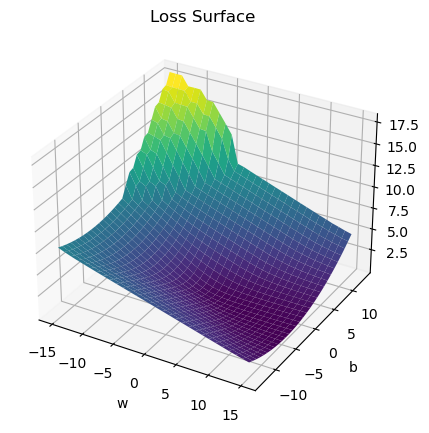

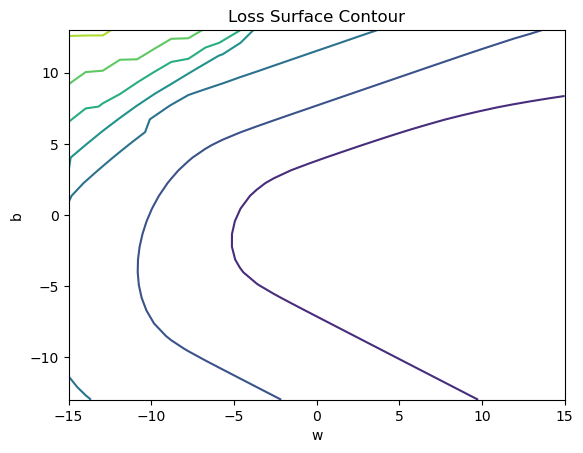

In [8]:
# Create the plot_error_surfaces object
get_surface = PlotErrorSurfaces(15, 13, dataset[:][0], dataset[:][1], 30)

<a name="3.3"></a>
### <font color='#1f618d'> <b> 3.3. Model </b> </font>

In [25]:
# Logistic Regression class
class LogisticRegression(nn.Module):
    
    # constructor
    def __init__(self, n_inputs):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(n_inputs, 1)
        
    # prediction
    def forward(self, x):
        yhat = torch.sigmoid(self.linear(x))
        return yhat


In [26]:
# Create the model
model = LogisticRegression(1)

In [27]:
# Set the weight and bias
model.state_dict()['linear.weight'].data[0] = torch.tensor([[-5]])
model.state_dict()['linear.bias'].data[0] = torch.tensor([[-10]])
print("The parameters: ", model.state_dict())

The parameters:  OrderedDict([('linear.weight', tensor([[-5.]])), ('linear.bias', tensor([-10.]))])


In [28]:
# criterion: Binary crossentropy loss
def criterion(yhat, y):
    """
    Computes the Binary Cross-Entropy (BCE) loss.
    
    Formula:
        Loss = -1/N * sum(y_i * log(yhat_i) + (1 - y_i) * log(1 - yhat_i))
    
    Args:
        yhat (torch.Tensor): Predicted probabilities, values between 0 and 1 (shape: [N]).
        y (torch.Tensor): Ground truth labels, values 0 or 1 (shape: [N]).
    
    Returns:
        torch.Tensor: The mean binary cross-entropy loss.
    
    Notes:
        - This implementation assumes yhat is already a probability (sigmoid applied).
        - For numerical stability, yhat values are clamped to avoid log(0).
    """
    # Clamp yhat to avoid log(0) issues
    yhat = torch.clamp(yhat, min=1e-7, max=1 - 1e-7)
    # Compute the binary cross-entropy loss
    return -torch.mean(y * torch.log(yhat) + (1 - y) * torch.log(1 - yhat))


In [29]:
# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 2)

In [30]:
# train loader
trainloader = DataLoader(dataset = dataset, batch_size = 3)

<a name="3.4"></a>
### <font color='#1f618d'> <b> 3.4. Training and evaluation </b> </font>

In [31]:
# train
def train_model(model, trainloader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        for x, y in trainloader:
            yhat = model(x)
            loss = criterion(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            get_surface.set_para_loss(model, loss.tolist())
        if epoch % 20 == 0:
            get_surface.plot_ps()
            
    return model

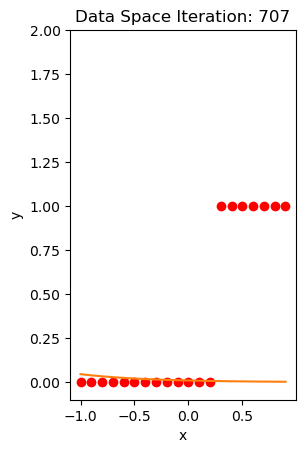

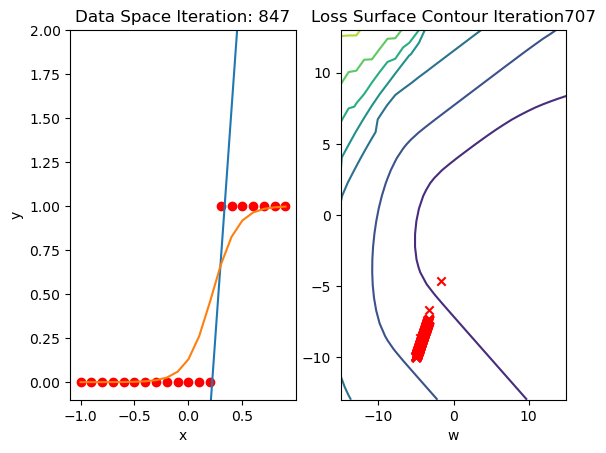

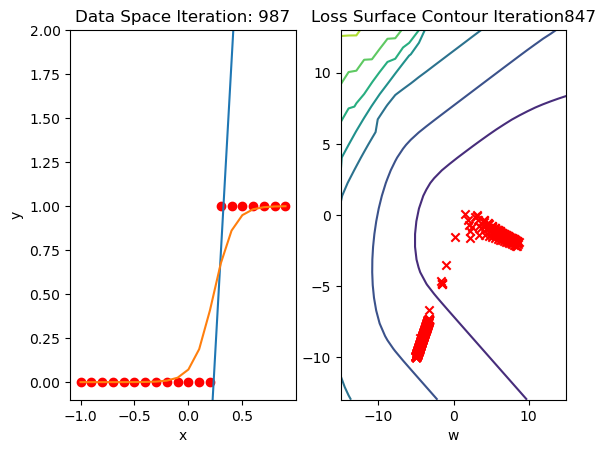

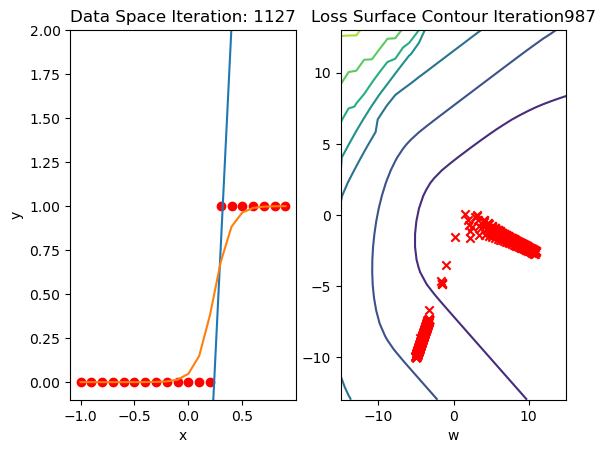

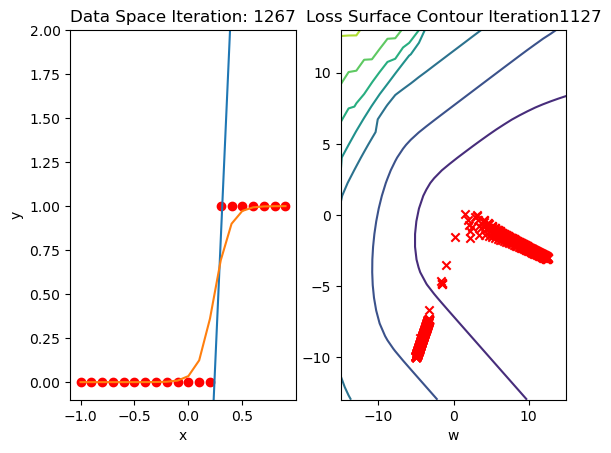

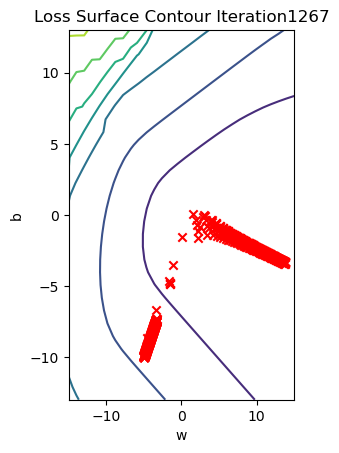

In [32]:
trained_model = train_model(model, trainloader, criterion, optimizer, 100)

In [34]:
# evaluation
def evaluate_model(model, dataset, threshold=0.5):
    yhat = model(dataset.x)
    label = yhat > threshold
    return torch.mean((label == dataset.y.type(torch.ByteTensor)).type(torch.float))
    


accuracy = evaluate_model(trained_model, dataset)    
print(f"Accuracy: {accuracy}")    


Accuracy: 1.0


**Note** Since this is an exercise where the goal is to learn about binary classification, we calculate the accuracy using the same data we trained the model on, but in a real problem, we should have training, validation, and test sets.

<a name="4"></a>
## <font color='blue'> <b> 4. Multiclass Classification </b> </font>


In a binary classification task, the goal is to categorize data into one of two classes, often labeled as 0 or 1. For example, predicting whether an email is spam (1) or not spam (0).

In a multiclass classification task, the goal is to classify data into one of three or more classes. Unlike binary classification, where the model only chooses between two categories, multiclass classification involves more than two possible outcomes. For instance, predicting which type of fruit is shown in an image could involve classes like "apple," "banana," or "cherry."

In this example, we are going to work with the MNIST dataset, which consists of handwritten digits (0-9). The goal is to classify each image into one of these 10 classes. While binary classification uses a simple decision boundary, multiclass classification typically employs techniques like one-vs-rest or softmax to handle multiple classes. The evaluation metrics also expand to handle the complexity of multiple classes, such as using accuracy, precision, recall, or F1 score across all classes.

<a name="4.1"></a>
### <font color='#1f618d'> <b> 4.1. Helper Functions </b> </font>

In [55]:
def plot_parameters(model): 
    # Get the weights of the linear layer from the model (assuming a model with a 'linear' layer).
    W = model.state_dict()['linear.weight'].data
    
    # Find the minimum and maximum values of the weight matrix to normalize the colormap.
    w_min = W.min().item()
    w_max = W.max().item()
    
    # Create a 2x5 grid of subplots for displaying 10 images (28x28 each).
    fig, axes = plt.subplots(2, 5)
    
    # Adjust space between subplots for better readability.
    fig.subplots_adjust(hspace=0.01, wspace=0.1)
    
    # Loop through the axes and plot the corresponding weight values as images.
    for i, ax in enumerate(axes.flat):
        if i < 10:  # Only plot the first 10 classes (0-9).
            
            # Set the label for the subplot with the corresponding class number.
            ax.set_xlabel("class: {0}".format(i))

            # Reshape the weights of each class (flattened 28x28) into a 28x28 image and plot it.
            ax.imshow(W[i, :].view(28, 28), vmin=w_min, vmax=w_max, cmap='seismic')

            # Remove the x and y axis ticks for better visualization.
            ax.set_xticks([])
            ax.set_yticks([])

    # Display the plot.
    plt.show()

    


def show_data(data_sample):
    # Reshape the data sample (assumed to be a 1D tensor of length 784) into a 28x28 image and display it.
    # Convert the tensor to a NumPy array and reshape it to 28x28 for visualization.
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')

    # Set the title of the plot to display the label of the data sample.
    # 'data_sample[1]' is assumed to be the label (e.g., 0-9 for MNIST)
    plt.title('y = ' + str(data_sample[1]))
    
    # Show the plot
    plt.show()


<a name="4.2"></a>
### <font color='#1f618d'> <b> 4.2. Data </b> </font>

We will use the MNIST data.

In [112]:
# load train dataset
train_dataset = dsets.MNIST(root='./', train=True, download=True, transform=transforms.ToTensor())
print("Print the training dataset:\n ", train_dataset)

Print the training dataset:
  Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: ToTensor()


In [113]:
# Create and print the validating dataset
validation_dataset = dsets.MNIST(root='./data', download=True, transform=transforms.ToTensor())
print("Print the validating dataset:\n ", validation_dataset)

Print the validating dataset:
  Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


Let's explore the data a little bit:

In [114]:
# Print the shape of train dataset
train_dataset[0][0].shape

torch.Size([1, 28, 28])

In [115]:
# Print the label
print("Label: ", train_dataset[5][1])

Label:  2


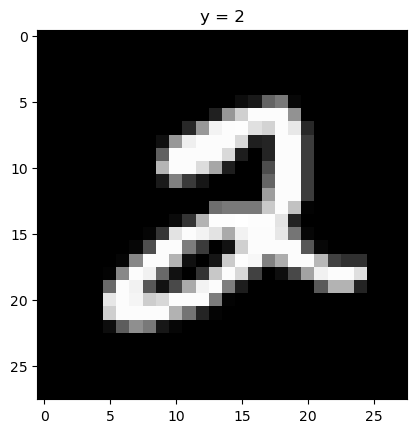

In [116]:
# Plot the image
show_data(train_dataset[5])

<a name="4.3"></a>
### <font color='#1f618d'> <b> 4.3. Model </b> </font>

We will build a softmax classifier.

In [118]:
# Define the softmax classifier
class SoftmaxClassifier(nn.Module):
    
    # constructor
    def __init__(self, input_size, output_size):
        super(SoftmaxClassifier, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    # prediction
    def forward(self, x):
        # Apply the linear transformation and then apply Softmax
        logits = self.linear(x)
        return torch.softmax(logits, dim = -1)  # Apply softmax across the output dimension


In [119]:
# Set input size and output size
input_dim = 28 * 28 # 28x28 images
output_dim = 10 # 10 outputs, digits from 0 to 9

In [120]:
model = SoftmaxClassifier(input_dim, output_dim)
print(f"Print the model:\n {model}")

Print the model:
 SoftmaxClassifier(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [122]:
# Print the parameters
print(f"W: ,{list(model.parameters())[0].size()}")
print(f"b: ,{list(model.parameters())[1].size()}")

W: ,torch.Size([10, 784])
b: ,torch.Size([10])


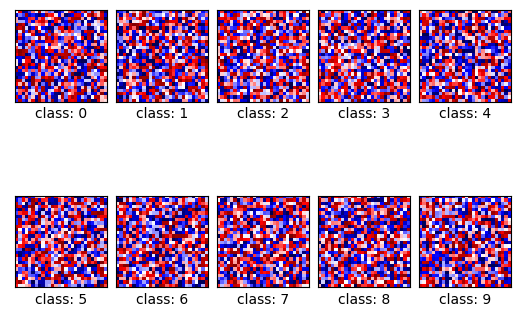

In [123]:
# Plot the model parameters for each class
plot_parameters(model)

In [124]:
# optimizer, cost and data loaders
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
criterion = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

In [126]:
def train_model(model, train_loader, val_loader, optimizer, criterion, N_test, epochs):
    
    loss_list = []
    accuracy_list = []
    
    for epoch in range(epochs):
        # train
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x.view(-1, 28*28))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            
        # validation
        correct = 0
        for x_test, y_test in val_loader:
            z = model(x_test.view(-1, 28*28))
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct/N_test
        
        # lists
        loss_list.append(loss.data)
        accuracy_list.append(accuracy)
        
    return model,loss_list, accuracy_list


In [127]:
N_test = len(validation_dataset)

In [128]:
trained_model, loss_list, accuracy_list = train_model(model, train_loader, validation_loader, optimizer,
                                                     criterion, N_test, 10)

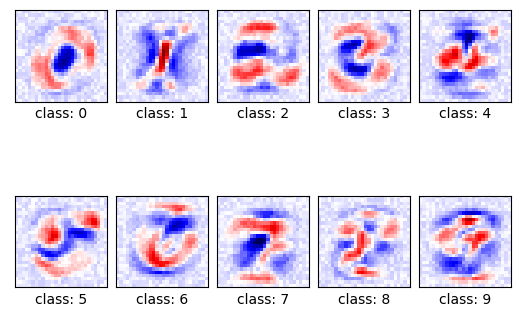

In [133]:
# Plot the model parameters for each class
plot_parameters(trained_model)

### Predictions

In [134]:
x = validation_dataset[0][0]

In [135]:
x.shape

torch.Size([1, 28, 28])

In [136]:
aux = x.reshape(-1, 28*28)
aux.shape

torch.Size([1, 784])

In [137]:
yhat = model(x.reshape(-1, 28 * 28))

In [138]:
yhat

tensor([[3.1317e-03, 8.2670e-07, 1.8712e-04, 1.5375e-01, 1.5133e-07, 8.3941e-01,
         1.2678e-04, 2.8671e-03, 4.5217e-04, 6.5590e-05]],
       grad_fn=<SoftmaxBackward0>)

In [139]:
torch.max(yhat, 1)

torch.return_types.max(
values=tensor([0.8394], grad_fn=<MaxBackward0>),
indices=tensor([5]))

In [140]:
torch.max(yhat, 1)[0], torch.max(yhat, 1)[1]

(tensor([0.8394], grad_fn=<MaxBackward0>), tensor([5]))

In [141]:
torch.max(yhat).item()

0.8394147157669067

### Correctly classified labels

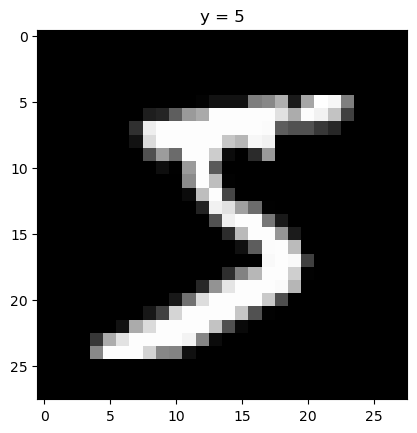

yhat: tensor([5])
Probability of class: 0.8394147157669067 


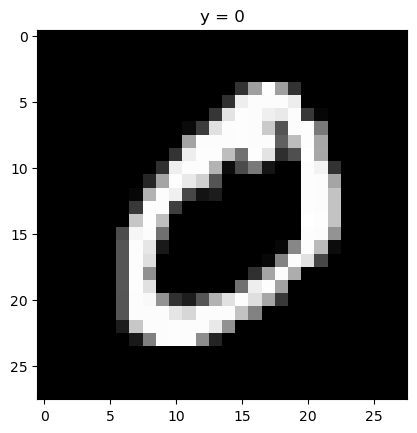

yhat: tensor([0])
Probability of class: 0.9997794032096863 


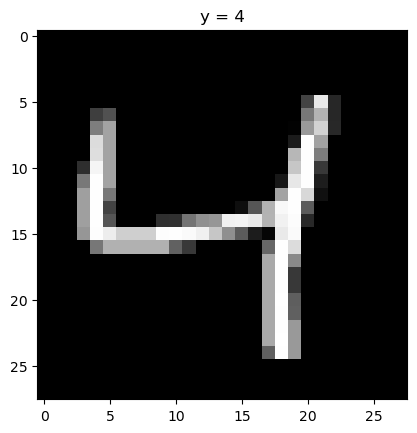

yhat: tensor([4])
Probability of class: 0.9718066453933716 


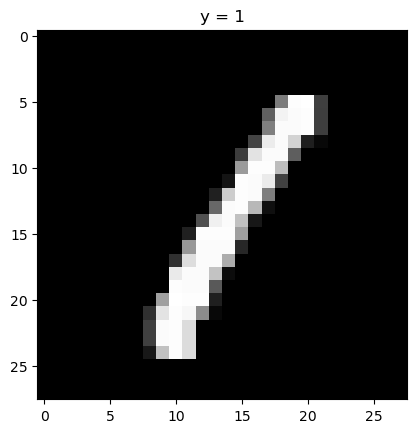

yhat: tensor([1])
Probability of class: 0.9925026893615723 


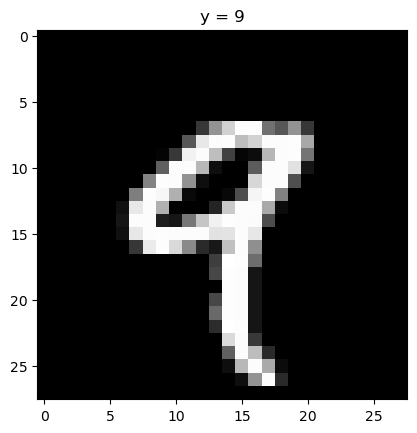

yhat: tensor([9])
Probability of class: 0.9838305115699768 


In [148]:
count = 0
for x, y in validation_dataset:
    z = model(x.reshape(-1, 28 * 28))
    prob, yhat = torch.max(z, 1)
    if yhat == y:
        show_data((x, y))
        plt.show()
        print(f"yhat: {yhat}")
        print(f"Probability of class: {prob.item()} ")
        count += 1
    if count >= 5:
        break 

### Misclassified labels

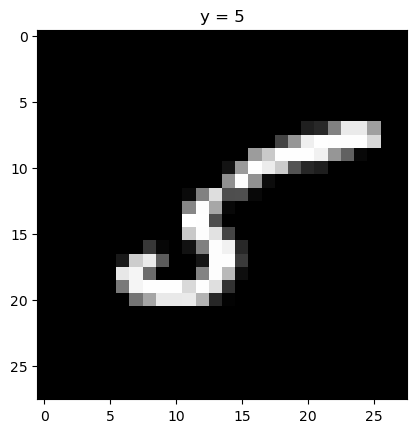

yhat: tensor([2])
Probability of class: 0.37207043170928955


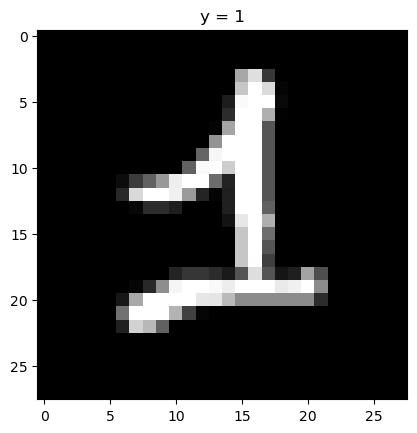

yhat: tensor([6])
Probability of class: 0.3512888252735138


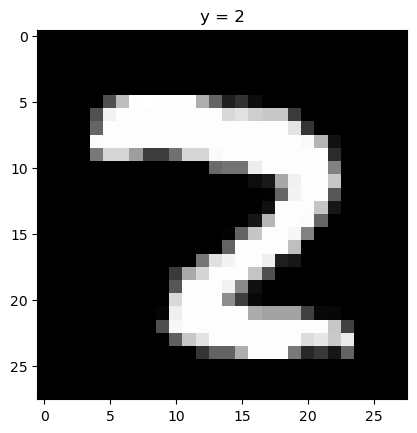

yhat: tensor([7])
Probability of class: 0.9958122372627258


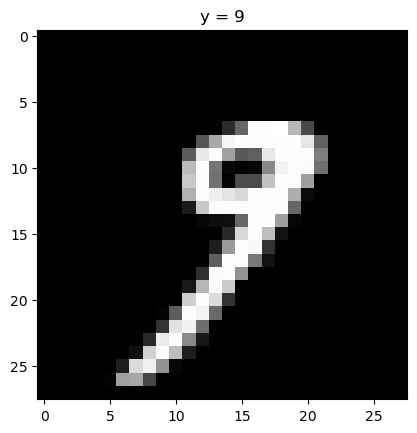

yhat: tensor([7])
Probability of class: 0.7605587244033813


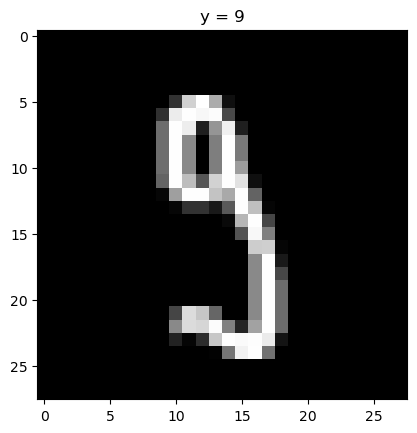

yhat: tensor([5])
Probability of class: 0.7412853837013245


In [149]:
count = 0
for x, y in validation_dataset:
    z = model(x.reshape(-1, 28 * 28))
    prob, yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x, y))
        plt.show()
        print(f"yhat: {yhat}")
        print(f"Probability of class: {prob.item()}")
        count += 1
    if count >= 5:
        break   

<a name="references"></a>
## <font color='blue'> <b> References </b> </font>

[IBM AI Engineering Professional Certificate](https://www.coursera.org/professional-certificates/ai-engineer)